In [115]:
import os
import cv2
import numpy as np
import pandas as pd
import pytesseract as tess
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.config import list_physical_devices
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [116]:
image_folder = "./data/fareselmenshawii/imgs/train/"
label_folder = "./data/fareselmenshawii/labels/train/"
sample_size = 5000

## Data processing

In [117]:
def get_image_paths():
    image_paths = []
    for file in os.listdir(image_folder):
        image_paths.append(image_folder + "/" + file)
        
    return image_paths

def get_label_paths():
    label_paths = []
    for file in os.listdir(label_folder):
        label_paths.append(label_folder + "/" + file)
        
    return label_paths

In [118]:
image_paths = get_image_paths()
label_paths = get_label_paths()

### Skip images that have more than one bounding box

In [119]:
lp2rmv = []
img2rmv = []
# Remove images that don't have labels, if any
for ip in image_paths:
    if ip.replace("imgs", "labels").replace(".jpg", ".txt") not in label_paths:
        img2rmv.append(ip)
        
# Remove labels that don't have images, if any
for lp in label_paths:
    if lp.replace("labels", "imgs").replace(".txt", ".jpg") not in image_paths:
        lp2rmv.append(ip)

print(len(img2rmv))
print(len(lp2rmv))


# Remove images that have two bounding boxes
# for lp in label_paths:
#     with open(lp, "r") as label_file:
#         if len(label_file.readlines()) > 1:
#             img2rmv.append(lp.replace("labels", "imgs").replace(".txt", ".jpg"))
#             to_remove.append(lp)

# label_paths = [lp for lp in label_paths if lp not in to_remove]


# Print number of entries
print("Number of images removed:", len(get_image_paths()) - len(image_paths))
print("Number of labels removed:", len(get_label_paths()) - len(label_paths))



0
0
Number of images removed: 0
Number of labels removed: 0


: 

In [ ]:
# Read the data
yolo_labels_dict = dict(image=[], x_center=[], y_center=[], width=[], height=[])

# Take only 5000 random images to build the model
label_paths = np.random.choice(label_paths, sample_size, replace=False)
for label_path in label_paths:
    with open(label_path, "r") as label_file:
        for line in label_file.readlines():
            # Read the YOLO annotation files
            parts = line.strip().split(" ")
            class_id = int(parts[0])
            if class_id != 0:
                print("Class ID is not 0: class=", class_id)
            
            yolo_labels_dict["image"].append(label_path.replace("labels", "imgs").replace(".txt", ".jpg"))
            yolo_labels_dict["x_center"].append(float(parts[1]))
            yolo_labels_dict["y_center"].append(float(parts[2]))
            yolo_labels_dict["width"].append(float(parts[3]))
            yolo_labels_dict["height"].append(float(parts[4]))

# Convert the data to a pandas dataframe
df = pd.DataFrame(yolo_labels_dict)
df = df.sample(sample_size).reset_index(drop=True)
df.head()

,image,x_center,y_center,width,height
0,./data/fareselmenshawii/imgs/train/CarLongPlat...,0.587740,0.698317,0.229567,0.099760
1,./data/fareselmenshawii/imgs/train/xemay70_jpg...,0.513221,0.459135,0.197115,0.260817
2,./data/fareselmenshawii/imgs/train/CarLongPlat...,0.393029,0.492788,0.131010,0.055288
3,./data/fareselmenshawii/imgs/train/87923704a3d...,0.681641,0.549597,0.113750,0.050293
4,./data/fareselmenshawii/imgs/train/CarLongPlat...,0.305288,0.457933,0.231971,0.123798


In [ ]:
# Print number of images in the dataset
print("Number of images in the dataset:", len(df["image"].unique()))
print("Number of images in the dataset:", len(df["image"]))

u = df["image"].unique()

# print duplicate rows by image
for i in range(len(u)):
    if len(df[df["image"] == u[i]]) > 1:
        print(u[i])


Number of images in the dataset: 4488
Number of images in the dataset: 5000
./data/fareselmenshawii/imgs/train/00a09b822d470896_jpg.rf.cb176d6cc5328f2590bc33086bbc9e05.jpg
./data/fareselmenshawii/imgs/train/f51b686b4c935dbc.jpg
./data/fareselmenshawii/imgs/train/8216958489c7ec48.jpg
./data/fareselmenshawii/imgs/train/e214ee0ccfac8cba.jpg
./data/fareselmenshawii/imgs/train/0137f744e31ab3ff_jpg.rf.ca602ce61855064c4e565bd6ce0d0339.jpg
./data/fareselmenshawii/imgs/train/5a0af48fed65fd32.jpg
./data/fareselmenshawii/imgs/train/brightnessquandoi91_jpg.rf.e2f913a092bd953cc6714e0ee4aa6b59.jpg
./data/fareselmenshawii/imgs/test/791d63b1c3499e4f.jpg
./data/fareselmenshawii/imgs/train/3865301bc034b9ec.jpg
./data/fareselmenshawii/imgs/train/f843e953b9f2d8e1.jpg
./data/fareselmenshawii/imgs/train/ad737e0bfa06f8a0.jpg
./data/fareselmenshawii/imgs/val/eee6410e336f26c1.jpg
./data/fareselmenshawii/imgs/val/e6879974a6aecefc.jpg
./data/fareselmenshawii/imgs/train/06501a5ed994c937.jpg
./data/fareselmenshawi

In [ ]:
def yolo_to_voc(row, img_w, img_h):
    x_center = row["x_center"]
    y_center = row["y_center"]
    width = row["width"]
    height = row["height"]

    x_min = int((x_center - width / 2) * img_w)
    y_min = int((y_center - height / 2) * img_h)
    x_max = int((x_center + width / 2) * img_w)
    y_max = int((y_center + height / 2) * img_h)

    return x_min, y_min, x_max, y_max

In [ ]:
def plot_image_with_bounding_box(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    row = df[df["image"] == image_path].iloc[0]
    x_min, y_min, x_max, y_max = yolo_to_voc(row, img.shape[1], img.shape[0])
    img = cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

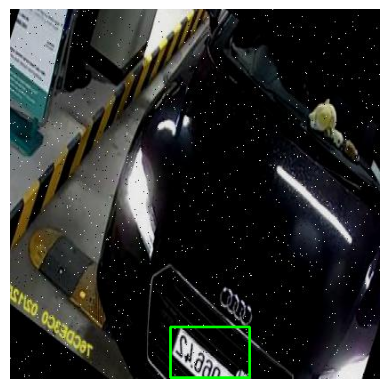

In [54]:
# Plot sample image with bounding boxes
row = df.sample(n=1)
image_path = row["image"].values[0]
plot_image_with_bounding_box(image_path)

## Data processing

In [75]:
# Convert images to array with VOC format labels
data = []
output = []

for i in range(len(df)):
    row = df.iloc[i]
    img_h, img_w, _ = cv2.imread(row["image"]).shape
    
    # Preprocess the image
    img_array = img_to_array(load_img(row["image"], target_size=(224, 224)))
    img_array = img_array / 255.0

    # Normalize the bounding box
    x_min, y_min, x_max, y_max = yolo_to_voc(row, img_w, img_h)
    x_min = x_min / img_w
    y_min = y_min / img_h
    x_max = x_max / img_w
    y_max = y_max / img_h

    data.append(img_array)
    output.append((x_min, y_min, x_max, y_max))


print("Number of images:", len(data))
print("Number of bounding boxes:", len(output))

Number of images: 5000
Number of bounding boxes: 5000


In [77]:
X = np.array(data, dtype=np.float32)
y = np.array(output, dtype=np.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4000, 224, 224, 3), (1000, 224, 224, 3), (4000, 4), (1000, 4))

In [81]:
inception_resnet = InceptionResNetV2(weights="imagenet",include_top=False, input_tensor=Input(shape=(224,224,3)))

head_model = inception_resnet.output
head_model = Flatten()(head_model)
head_model = Dense(500,activation="relu")(head_model)
head_model = Dense(250,activation="relu")(head_model)
head_model = Dense(4,activation='sigmoid')(head_model)

model = Model(inputs=inception_resnet.input, outputs=head_model)


219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [89]:
list_physical_devices('GPU')

[]

In [86]:
# Use GPU to train the model
# config = tf.compat.v1.ConfigProto(device_count = {'GPU': 1 , 'CPU': 4})
# sess = tf.compat.v1.Session(config=config)
# keras.backend.set_session(sess)

model.compile(loss="mean_squared_error", optimizer="adam")
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)
model.save("object_detection.h5")

NameError: name 'tf' is not defined